In [1]:
import sys
!{sys.executable} -m pip install cmdbench

In [2]:
import sys
import os
import shutil
import numpy as np
import glob

# Move two upper directories, import benchmark, revert cwd
sys.path.append("../..")
import cmdbench
sys.path.pop()

# Summarize numpy array if it has more than 10 elements
np.set_printoptions(threshold=10)

input_dir = 'input'
input_files_1 = [os.path.basename(f) for f in glob.glob('input/*_1.fastq.gz')]
input_samples = [f.replace('_1.fastq.gz','') for f in input_files_1]
print(input_samples)

bigsi_dir = 'bigsi-data'

['2014C-3598']


In [3]:
def clean_if_exists(path):
    if os.path.exists(path):
        if(os.path.isfile(path)):
            os.remove(path)
        else:
            shutil.rmtree(path)
    os.mkdir(path)
def get_last_n_lines(string, n):
    return "\n".join(string.split("\n")[-n:])



In [4]:
%%bash
# You might need to run this before starting jupyter notebook in your shell
export BIGSI_CONFIG=berkleydb.yaml

## Initialize benchmark data collection functions

In [13]:
def get_results_from_benchmarks_list(benchmark_firsts_list):
    return {
        "memory": max(list(map(lambda result: result.memory.max, benchmark_firsts_list))),
        "disk_read": max(list(map(lambda result: result.disk.read_chars, benchmark_firsts_list))),
        "disk_write": max(list(map(lambda result: result.disk.write_chars, benchmark_firsts_list))),
        "runtime": sum(list(map(lambda result: result.process.execution_time, benchmark_firsts_list)))
    }

def get_bigsi_resource_usage(num_samples, query_repeat_count, debugging = False):
    # Delete indexed data
    os.system("bigsi delete")

    # Delete all saved bigsi data
    clean_if_exists(bigsi_dir)
    
    input_subsamples = input_samples[:num_samples]
    
    index_debug_output, query_debug_output = "", ""

    # Preprocess and generate kmers

    command_mccortex = "parallel -j 4 -I% mccortex 31 build --nkmers 74000000 --threads 8 --kmer 31 " \
        + "--mem 20G --sample % --seq2 input/%_1.fastq.gz:input/%_2.fastq.gz bigsi-data/%.ctx ::: " \
        + ' '.join(input_subsamples)

    benchmark_results_mccortex = cmdbench.benchmark_command(command_mccortex)
    benchmark_results_mccortex_first = benchmark_results_mccortex.get_first_iteration()
    
    print(benchmark_results_mccortex_first.process.stdout_data)
    print(benchmark_results_mccortex_first.process.stderr_data)
    
    index_debug_output += command_mccortex + "\n"
    index_debug_output += get_last_n_lines(benchmark_results_mccortex_first.process.stderr_data, 10) + "\n"
    
    # Generate bloom filters from kmers

    command_bloom_filters = "parallel -j 12 -I% bigsi bloom -c berkleydb.yaml bigsi-data/%.ctx bigsi-data/%.bloom ::: " \
        + ' '.join(input_subsamples)
    
    benchmark_results_bloom_filters = cmdbench.benchmark_command(command_bloom_filters)
    benchmark_results_bloom_filters_first = benchmark_results_bloom_filters.get_first_iteration()
    
    print(benchmark_results_bloom_filters_first.process.stdout_data)
    print(benchmark_results_bloom_filters_first.process.stderr_data)
    
    index_debug_output += command_bloom_filters + "\n"
    index_debug_output += get_last_n_lines(benchmark_results_bloom_filters_first.process.stdout_data, 10) + "\n"
    
    # Index strains

    bloom_files = ' '.join([f'bigsi-data/{s}.bloom' for s in input_subsamples])
    samples_string = ' '.join([f'-s {s}' for s in input_subsamples])
    command_index_bloom_filters = f'bigsi build -c berkleydb.yaml {samples_string} {bloom_files}'
    
    benchmark_results_index_bloom_filters = cmdbench.benchmark_command(command_index_bloom_filters)
    benchmark_results_index_bloom_filters_first = benchmark_results_index_bloom_filters.get_first_iteration()
    
    print(benchmark_results_index_bloom_filters_first.process.stdout_data)
    print(benchmark_results_index_bloom_filters_first.process.stderr_data)
    
    index_debug_output += command_index_bloom_filters + "\n"
    index_debug_output += get_last_n_lines(benchmark_results_index_bloom_filters_first.process.stderr_data, 10) + "\n"
    
    # Make indexing benchmark results dictionary from all of the commands related to that step (indexing or querying)
    
    indexing_benchmark_firsts = [benchmark_results_mccortex_first, 
                                 benchmark_results_bloom_filters_first,
                                 benchmark_results_index_bloom_filters_first]
    
    index_results = get_results_from_benchmarks_list(indexing_benchmark_firsts)
    
    # QUERY

    test_sequence = "GAAGAAGATGGTGTACGCGGTGCGCGCCGCTATCTCGACCACCTTAAAATGGAATATGCCTTCTGGATGGACG"
    command_search = "parallel -j 1 -I% bigsi search % --config berkleydb.yaml -t 0.8 ::: {0}".format(" ".join([test_sequence] * query_repeat_count))

    benchmark_results_search = cmdbench.benchmark_command(command_search) 
    benchmark_results_search_first = benchmark_results_search.get_first_iteration()
    
    print(benchmark_results_search.get_first_iteration().process.stdout_data)
    print(benchmark_results_search.get_first_iteration().process.stderr_data)
    
    query_debug_output += command_search + "\n"
    query_debug_output +=  get_last_n_lines(benchmark_results_search.get_first_iteration().process.stderr_data, 10) + "\n"
    
    # Make query benchmark results dictionary
    
    query_results = get_results_from_benchmarks_list([benchmark_results_search_first])
    
    return_data = {"index": index_results, "query": query_results}
    
    if debugging:
        return_data["index_debug_output"] = index_debug_output
        return_data["index_query_output"] = query_debug_output
    
    return return_data

### Test the get_bigsi_resource_usage function

In [ ]:
# Number of times to run the query command as it is pretty fast comparing to our measurement tools
QUERY_REPEAT_COUNT = 1

for sample_size in [3, 6, 9]:
    print("Getting results for sample size %s" % sample_size)
    print()
    print(get_bigsi_resource_usage(sample_size, QUERY_REPEAT_COUNT, True))
    print()

Getting results for sample size 3


[22 Jun 2020 20:48:25-NiP][cmd] /home/manzik/anaconda3/envs/bigsi_mccortex/bin/mccortex31 build --nkmers 74000000 --threads 8 --kmer 31 --mem 20G --sample 2014C-3598 --seq2 input/2014C-3598_1.fastq.gz:input/2014C-3598_2.fastq.gz bigsi-data/2014C-3598.ctx

[22 Jun 2020 20:48:25-NiP][cwd] /home/manzik/Documents/cmdbench/repo/tests/bioinformatics

[22 Jun 2020 20:48:25-NiP][version] mccortex=v0.0.3-610-g400c0e3 zlib=1.2.11 htslib=1.8-17-g699ed53 ASSERTS=ON hash=Lookup3 CHECKS=ON k=3..31

[22 Jun 2020 20:48:25-NiP] Saving graph to: bigsi-data/2014C-3598.ctx

[22 Jun 2020 20:48:25-NiP][sample] 0: 2014C-3598

[22 Jun 2020 20:48:25-NiP][task] input/2014C-3598_1.fastq.gz; FASTQ offset: auto-detect, threshold: off; cut homopolymers: off; remove PCR duplicates: no; colour: 0

[22 Jun 2020 20:48:25-NiP][task] input/2014C-3598_2.fastq.gz; FASTQ offset: auto-detect, threshold: off; cut homopolymers: off; remove PCR duplicates: no; colour: 0

[22 Jun 2020 20:48:25

## Add averaging functions

In [6]:
from inspect import isfunction

# Helper method from cmdbench.result

# Gets of same-structured objects
# Returns object of that structure with list of values from those objects
# Replaces them with replace_func(list_of_objects) if provided (optional)
# Example: BenchmarkResults([{"x": 2}, {"x": 3}], None).get_values_per_attribute() == {"x": [2, 3]}
def get_values_per_attribute(list_of_objects, replace_func = None, key_path = []):
        sample_from_list = list_of_objects[0]
        if(isinstance(sample_from_list, dict)):
            value_per_attribute_dict = {}
            for key, value in sample_from_list.items():
                list_of_objects_from_key = list(map(lambda parent_dict: parent_dict[key], list_of_objects))
                value_per_attribute_dict[key] = get_values_per_attribute(list_of_objects_from_key, replace_func, key_path + [key])
            return value_per_attribute_dict
        else:
            values_list = list_of_objects
            if(replace_func is not None and isfunction(replace_func)):
                values_list = replace_func(values_list)
            return values_list
        
def two_dimensional_samples_avg(dicts_2d_list):
    sample_size_avgs_len = len(dicts_2d_list[0])
    sample_size_avgs = []
    
    for sample_index in range(sample_size_avgs_len):
        dicts_list = list(map(lambda lst: lst[sample_index], dicts_2d_list))
        avg_dict = get_values_per_attribute(dicts_list, lambda lst: sum(lst) / len(lst))
        sample_size_avgs.append(avg_dict)
    return sample_size_avgs

In [7]:
# Test the function
get_values_per_attribute([{"x": 2}, {"x": 3}])

{'x': [2, 3]}

## Perform benchmark data collection

In [8]:
# Number of iterations to run and use for averaging
ITERATIONS_COUNT = 10
# Number of times ot run the query iteslf (as it takes much less time compared to other steps)
QUERY_REPEAT_COUNT = 1

PRINT_EACH_ITERATION = True
PRINT_EACH_SAMPLE = False


# 2d array. Array of results of iterations. Each iteration is a list of results for each sample size
usage_results_iterations = []
sample_sizes = list([1, 2, 3, 4, 5, 6, 7, 8, 9])

for i in range(0, ITERATIONS_COUNT):
    iteration_usage_results = []
    
    if(PRINT_EACH_ITERATION):
        print("Iteration {0}/{1}".format(i + 1, ITERATIONS_COUNT))
    
    for ind, sample_size in enumerate(sample_sizes):
        if(PRINT_EACH_SAMPLE):
            print("Getting results for sample size {0} ({1}/{2})".format(sample_size, ind + 1, len(sample_sizes)))
        
        usage_result = get_bigsi_resource_usage(sample_size, QUERY_REPEAT_COUNT, False)
        iteration_usage_results += [usage_result]
        
        if(PRINT_EACH_SAMPLE):
            print(usage_result)
            print()
            
    usage_results_iterations.append(iteration_usage_results)
    
usage_results_avg = two_dimensional_samples_avg(usage_results_iterations)

Iteration 1/10
Iteration 2/10
Iteration 3/10
Iteration 4/10
Iteration 5/10
Iteration 6/10
Iteration 7/10
Iteration 8/10
Iteration 9/10
Iteration 10/10


## Plotting

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np
from pylab import rcParams
rcParams['figure.figsize'] = 15, 3

In [10]:
def plot_resources(key):
    results = list(map(lambda result: result[key], usage_results_avg))
    print(results)
    
    memory_usages = list(map(lambda result: result["memory"], results))
    disk_write_usages = list(map(lambda result: result["disk_write"], results))
    disk_read_usages = list(map(lambda result: result["disk_read"], results))
    runtime_usages = list(map(lambda result: result["runtime"], results))
    
    fig, ax = plt.subplots(1, 4)
    
    plt1, plt2, plt3, plt4 = ax
    
    label_descriptions = {
        "o": "Disk write",
        ">": "Disk read",
        "s": "Memory usage",
        "^": "Runtime"
    }
    
    plt1.plot(sample_sizes, disk_write_usages, '-o', color='green', label=label_descriptions['o'])
    plt2.plot(sample_sizes, disk_read_usages, '-o', color='green', label=label_descriptions['o'])
    plt3.plot(sample_sizes, memory_usages, '-s', color='blue', label=label_descriptions['s'])
    plt4.plot(sample_sizes, runtime_usages, '-^', color='red', label=label_descriptions['^'])
    
    # plt.legend(numpoints=1, bbox_to_anchor=(1.04,1), loc="upper left")
    
    plt1.set_xlabel('Sample size', fontsize = 16)
    plt2.set_xlabel('Sample size', fontsize = 16)
    plt3.set_xlabel('Sample size', fontsize = 16)
    plt4.set_xlabel('Sample size', fontsize = 16)
    
    plt1.set_ylabel('Disk write', fontsize = 16)
    plt2.set_ylabel('Disk read', fontsize = 16)
    plt3.set_ylabel('Memory usage', fontsize = 16)
    plt4.set_ylabel('Runtime', fontsize = 16)
    
    plt.suptitle(key, fontsize = 20)

[{'memory': 951625318.4, 'disk_read': 17671290.0, 'disk_write': 10051316.2, 'runtime': 5.86}, {'memory': 1719656038.4, 'disk_read': 26921290.0, 'disk_write': 19342943.6, 'runtime': 5.8420000000000005}, {'memory': 2513004544.0, 'disk_read': 36171290.0, 'disk_write': 28642899.4, 'runtime': 5.931}, {'memory': 3305549004.8, 'disk_read': 47057607.5, 'disk_write': 37944198.5, 'runtime': 6.05}, {'memory': 3348923187.2, 'disk_read': 59893143.1, 'disk_write': 47216836.4, 'runtime': 6.5569999999999995}, {'memory': 3287473766.4, 'disk_read': 70968096.8, 'disk_write': 56523448.7, 'runtime': 6.736}, {'memory': 3315388416.0, 'disk_read': 82069928.4, 'disk_write': 65835619.3, 'runtime': 7.029999999999999}, {'memory': 3390497177.6, 'disk_read': 93313847.1, 'disk_write': 75150908.1, 'runtime': 7.76}, {'memory': 3362643148.8, 'disk_read': 105643740.1, 'disk_write': 84463590.3, 'runtime': 8.610999999999999}]


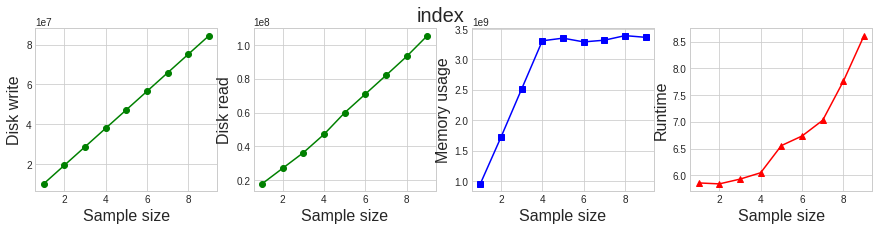

In [11]:
# Indexing Plots
plot_resources("index")

[{'memory': 266591846.4, 'disk_read': 10640625.6, 'disk_write': 587993.8, 'runtime': 0.5}, {'memory': 266530406.4, 'disk_read': 10641244.9, 'disk_write': 589756.5, 'runtime': 0.507}, {'memory': 266408345.6, 'disk_read': 10641745.7, 'disk_write': 586399.0, 'runtime': 0.499}, {'memory': 266492313.6, 'disk_read': 10644300.0, 'disk_write': 592335.7, 'runtime': 0.5159999999999999}, {'memory': 266651238.4, 'disk_read': 10642104.1, 'disk_write': 589765.7, 'runtime': 0.5049999999999999}, {'memory': 265853747.2, 'disk_read': 10642262.1, 'disk_write': 591465.6, 'runtime': 0.502}, {'memory': 266013900.8, 'disk_read': 10642329.6, 'disk_write': 585830.6, 'runtime': 0.48599999999999993}, {'memory': 266207641.6, 'disk_read': 10640297.0, 'disk_write': 584841.6, 'runtime': 0.48600000000000004}, {'memory': 266536140.8, 'disk_read': 10639839.8, 'disk_write': 587315.9, 'runtime': 0.488}]


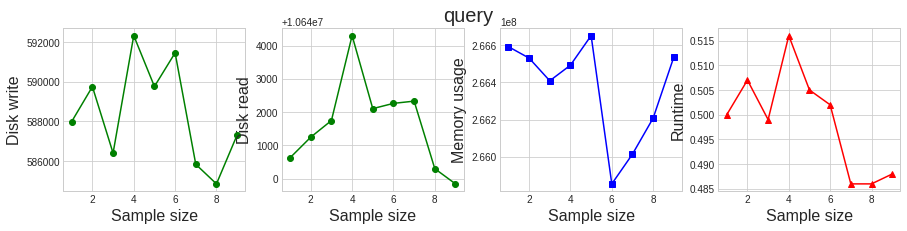

In [12]:
# Querying Plots
plot_resources("query")